In this Notebook, we implemented Gradient Boositng Trees to better perform on classification errors.

# Extraction

In [ ]:
!pip install -U -q PyDrive
!pip install -U scikit-learn
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import seaborn as sn

link="https://drive.google.com/open?id=1ekH_MmN_ofsmz6bR3xHrRnmDfXSDCWQK"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')
hSSW_wdeltabike= pd.read_csv('myfile.csv')
print('hSSW_wdeltabike imported')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22)
hSSW_wdeltabike imported


In [ ]:
hSSW_wdeltabike

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,634687,70,6,13,False,True,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,19,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634688,634688,71,5,14,False,True,Powell at Post (Union Square),37.788446,-122.408499,19,San Francisco,8/23/2013,-2.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634689,634689,72,14,9,False,True,Civic Center BART (7th at Market),37.781039,-122.411748,23,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634690,634690,73,10,4,False,True,Grant Avenue at Columbus Avenue,37.798522,-122.407245,15,San Francisco,8/21/2013,-3.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1


In [ ]:
hSSW_wdeltabike['city'].unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

# Coherence Check and Cleaning

<BarContainer object of 14 artists>

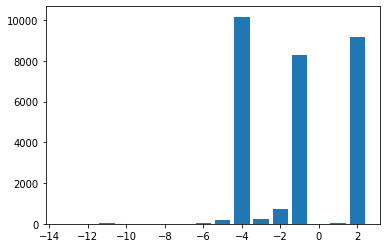

In [ ]:
hSSW_wdeltabike['check']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']-hSSW_wdeltabike['dock_count']
unique,count=np.unique(hSSW_wdeltabike['check'],return_counts=True)
plt.bar(np.delete(unique,-3),np.delete(count,-3)) #delete count of value 0

<BarContainer object of 69 artists>

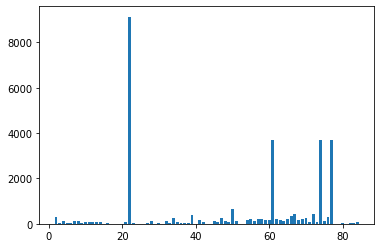

In [ ]:
unique_id,count_id=np.unique(hSSW_wdeltabike[hSSW_wdeltabike['check']!=0]['station_id'],return_counts=True)
plt.bar(unique_id,count_id)

In [ ]:
unique_id,count_id

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 21, 22, 23,
        24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
        45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82, 83,
        84], dtype=int64),
 array([ 298,   56,  124,   52,   38,  105,  110,   33,   78,   78,   83,
          98,   84,   50,   60, 9130,   22,    2,    4,   23,  122,    2,
          22,    5,  112,   45,  257,   70,   15,   30,   26,  382,  162,
         100,  133,   63,  261,  104,   79,  667,  110,  147,  227,  107,
         200,  212,  174,  161, 3675,  198,  170,  133,  207,  341,  434,
         172,  223,  246,   82,  434,   66, 3715,  118,  317, 3714,   19,
          56,   32,   66]))

In [ ]:
count_id[np.argsort(count_id)[-4:]],unique_id[np.argsort(count_id)[-4:]]

(array([3675, 3714, 3715, 9130]), array([61, 77, 74, 22], dtype=int64))

In [ ]:
np.unique(hSSW_wdeltabike[hSSW_wdeltabike['station_id']==22]['check'],return_counts=True)

(array([-1,  0,  1,  2], dtype=int64), array([   3,  250,   39, 9088]))

We can certainly deduce an error in the dock count. In addition, the number of bikes and docks available is varaible, contrary to the dock_count, which is fixed. If some docks are under repair, we will see them in the availability variable, but not in the dock_count.

In [ ]:
np.unique(hSSW_wdeltabike['dock_count'],return_counts=True)

(array([11, 15, 19, 23, 25, 27], dtype=int64),
 array([ 34598, 300137, 168663,  84397,   9380,  37517]))

In [ ]:
hSSW_wdeltabike['dock_total']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']

# Categorical Label Implementation

In [ ]:
hSSW_wdeltabike['Category']=1

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['bikes_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=0
hSSW_wdeltabike.loc[(hSSW_wdeltabike['docks_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=2

# Features Selection and Modification

### City

In [ ]:
City=pd.get_dummies(hSSW_wdeltabike['city'])
City.head()

,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


### Weather

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

Goal: Simplify the Weather Description to a more General weather:
- Sunny: Sky is clear
- Cloudy: Broken clouds, Few clouds, Scattered clouds, Overcast clouds
- Foggy: Mist, Fog, Haze, 
- Light Rain: light rain, light intensity drizzle, thunderstorm with light rain,light intensity shower rain
- Moderate Rain: moderate rain, drizzle, thunderstorm with rain
- Heavy Rain: heavy intensity rain, heavy intensity drizzle, thunderstorm with heavy rain, very heavy rain
- Proximity to Rain: thunderstorm, proximity thunderstorm, proximity shower rain, proximity thunderstorm with rain

In [ ]:
hSSW_wdeltabike['Weather_Simplified']=hSSW_wdeltabike['Weather_Description']

In [ ]:
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='sky is clear','Weather_Simplified']='Sunny'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='broken clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='few clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='scattered clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='overcast clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='mist','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='fog','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='haze','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity drizzle','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity shower rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='moderate rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='drizzle','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity drizzle','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='very heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity shower rain','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm with rain','Weather_Simplified']='Proximity to Rain'

In [ ]:
hSSW_wdeltabike['Rain']=1
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Sunny','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Cloudy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Foggy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Proximity to Rain','Rain']=0

Weather Description from 23 to 7 categories, and an additional dummy Rain column.

In [ ]:
Weather_Simplified=pd.get_dummies(hSSW_wdeltabike['Weather_Simplified'])
Weather_Simplified.head()

,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


### Wind Direction

In [ ]:
hSSW_wdeltabike['Wind_Orientation']='North'

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>45) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=135),'Wind_Orientation']='East'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>135) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=225),'Wind_Orientation']='South'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>225) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=315),'Wind_Orientation']='West'

In [ ]:
Wind_Orientation=pd.get_dummies(hSSW_wdeltabike['Wind_Orientation'])
Wind_Orientation.head()

,East,North,South,West
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


### Time

In [ ]:
hSSW_wdeltabike['Hour']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.hour
hSSW_wdeltabike['Month']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.month

In [ ]:
hSSW_wdeltabike.head()

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed,check,dock_total,Category,Weather_Simplified,Rain,Wind_Orientation,Hour,Month
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,27,0,Cloudy,0,South,13,8
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,11,0,Cloudy,0,South,13,8
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,19,1,Cloudy,0,South,13,8
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8


### Merge

In [ ]:
ML_data2=hSSW_wdeltabike[['Category','station_id','Weekend','city','Hour','Month','Humidity','Pressure','Temperature','Wind_Direction','Wind_Orientation','Wind_Speed','Weather_Simplified','Rain']]

In [ ]:
ML_data=hSSW_wdeltabike[['Category','station_id','bikes_available','docks_available','Holiday','Weekend','Humidity','Pressure','Temperature',\
                         'Wind_Direction','Wind_Speed','Rain','Hour','Month']]

In [ ]:
ML_data=pd.merge(ML_data,City,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Weather_Simplified,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Wind_Orientation,left_index=True,right_index=True)

In [ ]:
ML_data=ML_data.astype({'Holiday': int, 'Weekend': int})

In [ ]:
ML_data

,Category,station_id,bikes_available,docks_available,Holiday,Weekend,Humidity,Pressure,Temperature,Wind_Direction,Wind_Speed,Rain,Hour,Month,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny,East,North,South,West
0,0,2,2,25,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,1,3,9,6,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,4,0,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
3,1,5,9,10,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
4,1,6,4,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,1,70,6,13,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634688,1,71,5,14,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634689,1,72,14,9,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634690,1,73,10,4,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
ML_data2

,Category,station_id,Weekend,city,Hour,Month,Humidity,Pressure,Temperature,Wind_Direction,Wind_Orientation,Wind_Speed,Weather_Simplified,Rain
0,0,2,False,San Jose,13,8,94.0,1021,287.2795,201,South,0,Cloudy,0
1,1,3,False,San Jose,13,8,94.0,1021,287.2795,201,South,0,Cloudy,0
2,0,4,False,San Jose,13,8,94.0,1021,287.2795,201,South,0,Cloudy,0
3,1,5,False,San Jose,13,8,94.0,1021,287.2795,201,South,0,Cloudy,0
4,1,6,False,San Jose,13,8,94.0,1021,287.2795,201,South,0,Cloudy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,1,70,True,San Francisco,14,9,100.0,1024,286.7370,159,South,1,Sunny,0
634688,1,71,True,San Francisco,14,9,100.0,1024,286.7370,159,South,1,Sunny,0
634689,1,72,True,San Francisco,14,9,100.0,1024,286.7370,159,South,1,Sunny,0
634690,1,73,True,San Francisco,14,9,100.0,1024,286.7370,159,South,1,Sunny,0


# Machine Learning Models

### Gradient Boosting

We trained Gradient Boosting Trees Models, firstly on our full dataset.

In [ ]:
data1=ML_data.copy()

In [ ]:
data1.drop(columns=['bikes_available','docks_available','North','South','East','West'],inplace=True)

In [ ]:
X1_rest,X1_test,Y1_rest,Y1_test=train_test_split(data1.drop(columns=['Category']),data1['Category'],train_size=0.8,shuffle=True)

In [ ]:
X1_train,X1_validation,Y1_train,Y1_validation=train_test_split(X1_rest,Y1_rest,train_size=0.8,shuffle=True)

In [ ]:
model1=GradientBoostingClassifier(max_depth=10,verbose=2,learning_rate=0.25)

In [ ]:
model1.fit(X1_train,Y1_train)

      Iter       Train Loss   Remaining Time 
         1       57830.2271            9.36m
         2       53848.0165            9.43m
         3       51076.2131            9.45m
         4       48991.6267            9.44m
         5       47269.9573            9.39m
         6       45953.4975            9.33m
         7       44427.0372            9.28m
         8       42964.6910            9.24m
         9       41518.9842            9.19m
        10       40532.0871            9.11m
        11       39641.4777            9.02m
        12       38841.5067            8.94m
        13       37932.3254            8.85m
        14       37303.4617            8.76m
        15       36672.7837            8.66m
        16       35839.4699            8.56m
        17       35013.8050            8.47m
        18       34399.6903            8.37m
        19       33670.9672            8.27m
        20       32873.6102            8.17m
        21       32100.2600            8.07m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

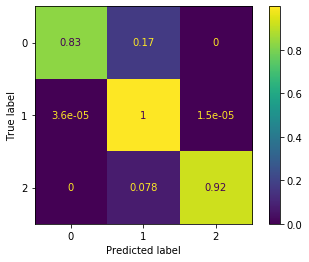

In [ ]:
CM1_training=plot_confusion_matrix(model1,X1_train,Y1_train,normalize='true')

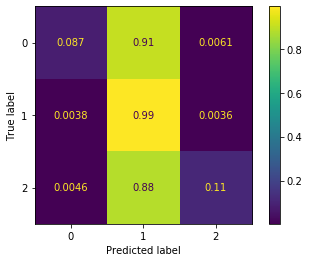

In [ ]:
CM1_validation=plot_confusion_matrix(model1,X1_validation,Y1_validation,normalize='true')

We observe pretty good results on the training set, but we are not able to transfer this performance to the validation set. We are overfitting a lot.

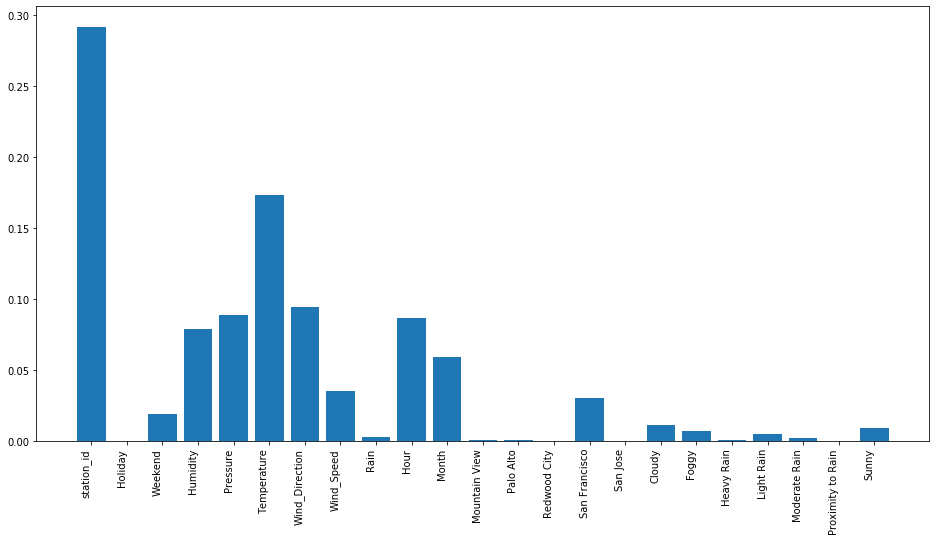

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(X1_train.columns,model1.feature_importances_)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

We trained a second model by selecting only the best features.

In [ ]:
data2=ML_data.copy()

In [ ]:
data2=data2[['Category','station_id','Hour','Month','Weekend','Temperature','Wind_Direction','Pressure','Humidity','Wind_Speed']]

In [ ]:
X2_rest,X2_test,Y2_rest,Y2_test=train_test_split(data2.drop(columns=['Category']),data2['Category'],train_size=0.8,shuffle=True)
X2_train,X2_validation,Y2_train,Y2_validation=train_test_split(X2_rest,Y2_rest,train_size=0.8,shuffle=True)

In [ ]:
model2=GradientBoostingClassifier(verbose=2,max_depth=10,learning_rate=0.25)

In [ ]:
model2.fit(X2_train,Y2_train)

      Iter       Train Loss   Remaining Time 
         1       57651.4607            7.50m
         2       53669.9356            7.62m
         3       51252.2476            7.59m
         4       49371.7749            7.53m
         5       47717.0415            7.47m
         6       46317.3101            7.42m
         7       44773.9659            7.38m
         8       43173.8797            7.32m
         9       41977.5988            7.25m
        10       41174.3466            7.16m
        11       40356.5744            7.09m
        12       39094.2440            7.01m
        13       38127.1658            6.94m
        14       37098.1364            6.88m
        15       36092.0457            6.80m
        16       35528.7000            6.71m
        17       35135.0242            6.63m
        18       34388.4722            6.55m
        19       33730.5442            6.46m
        20       33149.0385            6.37m
        21       32550.6420            6.29m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

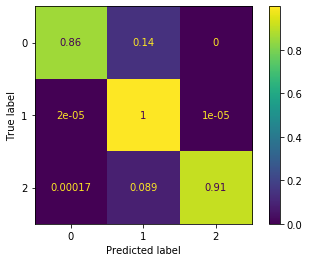

In [ ]:
CM2_training=plot_confusion_matrix(model2,X2_train,Y2_train,normalize='true')

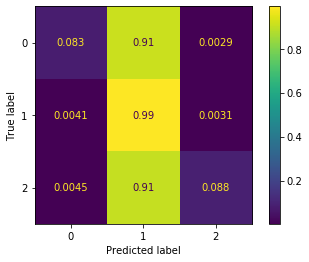

In [ ]:
CM2_validation=plot_confusion_matrix(model2,X2_validation,Y2_validation,normalize='true')

Again, we overfit too much.

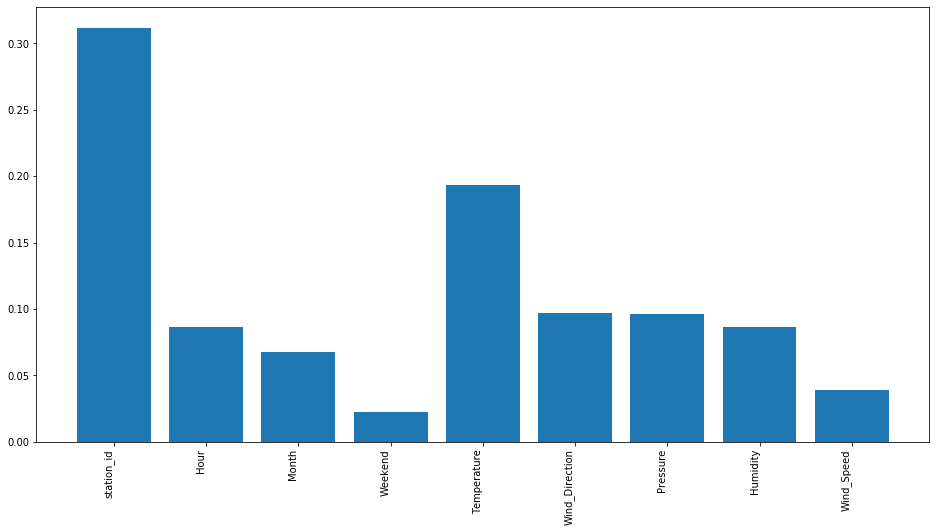

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(X2_train.columns,model2.feature_importances_)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

To avoid overfitting, we run a GridSearch to find the optimal max_depth. The learning rate was validated by cross-validation by hand (test of several models, and selection on the validation set).

In [ ]:
base_model=GradientBoostingClassifier(verbose=1,learning_rate=0.25)

In [ ]:
max_depth=np.arange(1,16)

In [ ]:
parameters={'max_depth':max_depth}

In [ ]:
model_GS=GridSearchCV(base_model,parameters,cv=3,return_train_score=True,verbose=2)

In [ ]:
model_GS.fit(X2_rest,Y2_rest)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] max_depth=1 .....................................................
      Iter       Train Loss   Remaining Time 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


         1       56752.9391            1.01m
         2       55947.1668           59.51s
         3       55465.5520           58.59s
         4       55212.8589           57.78s
         5       54980.3749           56.88s
         6       54838.6478           56.11s
         7       54671.2546           55.42s
         8       54593.8384           54.90s
         9       54472.4576           54.31s
        10       54384.2285           53.50s
        20       53707.1545           47.29s
        30       53329.3503           41.04s
        40       53047.4823           35.20s
        50       52852.4349           29.32s
        60       52711.9458           23.42s
        70       52584.9433           17.57s
        80       52477.1686           11.70s
        90       52382.3903            5.86s
       100       52293.0335            0.00s
[CV] ...................................... max_depth=1, total=  59.0s
[CV] max_depth=1 .....................................................
   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.7s remaining:    0.0s


         1       56792.4993            1.01m
         2       56015.6499           59.05s
         3       55549.5632           58.68s
         4       55284.4790           57.77s
         5       55077.1626           56.99s
         6       54944.3125           56.19s
         7       54797.6552           55.49s
         8       54721.1586           54.64s
         9       54636.4806           54.15s
        10       54530.7066           53.44s
        20       53950.3479           47.33s
        30       53565.2447           41.31s
        40       53326.8820           35.50s
        50       53139.7230           29.59s
        60       52995.8836           23.65s
        70       52882.2502           17.71s
        80       52774.5132           11.80s
        90       52679.9434            5.90s
       100       52609.6212            0.00s
[CV] ...................................... max_depth=1, total=  59.4s
[CV] max_depth=1 .....................................................
   

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 264.7min finished


         1       85146.9092            1.54m
         2       83957.3303            1.52m
         3       83243.4455            1.50m
         4       82836.7438            1.48m
         5       82522.1036            1.47m
         6       82319.3398            1.44m
         7       82085.3846            1.43m
         8       81971.6616            1.42m
         9       81843.1235            1.40m
        10       81702.3843            1.39m
        20       80715.1853            1.22m
        30       80178.0132            1.07m
        40       79783.9175           54.83s
        50       79526.7366           45.73s
        60       79292.6186           36.56s
        70       79115.4948           27.41s
        80       78963.4147           18.26s
        90       78819.5798            9.12s
       100       78693.5205            0.00s


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.25,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
        

In [ ]:
model_GS.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

At the end of the GridSearch, we conclude that the best Gradient Boosting Tree has only a depth of 1, which is a very simple model.

To conclude, Machine Learning models, except the KNN model, alone are pretty bad, because they can't handle the minority datas. We will try an Oversampling method, called SMOTE, to solve this problem.